#  Abnormality Module을 사용한 MNIST Classification

<h5>MNIST를 이용한 classification model에 영어 알파벳이 input 된다면?</h5>

위 질문에 답을 하기 위하여 여러 논문을 읽게 되었습니다. 그 중, 아래의 논문을 접하게 되었고 구현이 그나마 쉬울 것 같아서 몇몇 진정한 전문가분들의 도움 하에 아래의 코드를 작성하게 되었습니다. <b>피드백은 언제나 환영합니다.</b>

'A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks' (https://arxiv.org/abs/1610.02136) 논문을 보시면, 저자인 Hendrycks와 Gimpel은 classifier 마지막에 probability를 계산할 때 널리 사용되는 softmax 함수에 대해 의구심을 표현합니다. 이는 softmax의 exponentinality 성질에 따른 high-confidence problem 때문입니다. 비록 논문 자체에서는 softmax로도 어느 정도 abnormality를 잡아낼 수 있다고 하지만, 저자는 한걸음 더 나아가서 abnormality를 검증할 수 있는 새로운 방법인 auxiliary decoder (Zhang et al., 2016)을 소개합니다.

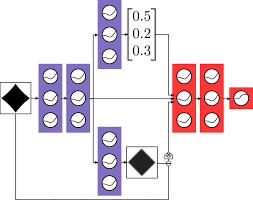</img>

<h4><center>Figure: Abnormality Module Example </center></h4>


논문에서 저자가 auxiliary decoder를 이용한 abnormality module을 학습한 과정은 다음과 같습니다:

1. Decoder와 scorer가 in-distribution 샘플들을 이용하여 동시에 학습된다.
2. 위 그림의 파란색 layer들의 weight값들을 고정한다.
3. 붉은색 layer를 원본 이미지와 오염 이미지(out-distribution)들을 이용하여 학습한다.
4. 학습 후, 우리는 결과적으로 보통 classifier, auxiliary decoder, 그리고 우리가 부르는 abnormality module을 가지게 된다. Abnormality module을 통해서 얻어지는 결과물은 기존 baseline model보다 더 좋은 성능을 낼 수 있음을 보여준다 (논문 참조).

위의 구체적인 설명 및 이상수님(https://github.com/2sang)의 코드를 바탕으로, abnormality module을 한번 구현해보았습니다

### 0. Importing Modules and Load Dataset

Abnormality module을 구현하기 위한 데이터로는 유명한 MNIST를 사용하였습니다.

In [1]:
import os
import numpy as np

import keras.backend as K

import keras
from keras.layers import Input, Dense
from keras.models import Model, save_model, load_model
from noise_util import add_distortion_noise, add_distortion_blur
from noise_util import rotate90_if_not_zero

import matplotlib.pyplot as plt
import sklearn.metrics as sk
% matplotlib inline

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
##### Load MNIST dataset

mnist = keras.datasets.mnist
(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = mnist.load_data()

mnist_train_x = np.reshape(mnist_train_x, [-1, 28*28]) / 255.
mnist_test_x = np.reshape(mnist_test_x, [-1, 28*28]) / 255.

### 1. in-distribution 샘플들을 이용한 Decoder & Scorer 학습

아래의 코드는 in-distribution 데이터를 사용하여 Decoder와 Scorer를 동시에 학습하는 과정입니다. 이 때, 'Output 'h2' missing from loss dictionary'라는 경고문이 나타나는데, 이는 h2를 더 잘 만들기 위한 loss function이 없다는 경고입니다. 사실 여기서는 그냥 나오는 h2를 추후 abnormality module의 input으로 사용할 것이기 때문에 굳이 잘 만들 필요가 없습니다. 

In [3]:
##### Set parameters
training_epochs = 10
image_size = 28
input_dim = image_size * image_size
n_labels = 10
bottleneck_dim = 128
batch_size = 128

##### Base model
inputs = Input(shape=(input_dim, ), name='image_input')
h1 = Dense(256, activation='relu', name='h1')(inputs)
h2 = Dense(256, activation='relu', name='h2')(h1)

##### Scorer
h3 = Dense(256, activation='relu', name='h3')(h2)
logits_out = Dense(n_labels, activation='softmax', name='logits_out')(h3)

##### Decoder
bottleneck = Dense(bottleneck_dim,
                   activation='relu',
                   name='bottleneck')(h2)
decode1 = Dense(256, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(256, activation='relu', name='decode2')(decode1)
reconstruction = Dense(input_dim, name='rec_output')(decode2)

##### Instantiate base model
base_model = Model(inputs, [h2, logits_out, reconstruction], name='base')

print(base_model.summary())

base_model.compile(optimizer='adam',
                   loss={'logits_out': 'sparse_categorical_crossentropy',
                         'rec_output': 'mean_squared_error'},
                   loss_weights={'logits_out': 0.9,
                                 'rec_output': 0.1})

##### Train base model
base_model.fit(mnist_train_x,
               {'logits_out': mnist_train_y,
                'rec_output': mnist_train_x},
               validation_data = (mnist_test_x, {'logits_out': mnist_test_y, 'rec_output' : mnist_test_x}),
               epochs=training_epochs, batch_size=batch_size)

# test_loss, test_acc
test_result = base_model.evaluate(x = mnist_test_x,
                                  y = {'logits_out': mnist_test_y,'rec_output': mnist_test_x})


print("metric names:", base_model.metrics_names)


print(test_result)

# ##### SAVE MODEL
# save_model(base_model, "./mnist_aux_base.hdf5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
decode1 (D

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Output "h2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "h2" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 85us/step - loss: 0.2277 - logits_out_loss: 0.2491 - rec_output_loss: 0.0344 - val_loss: 0.0975 - val_logits_out_loss: 0.1057 - val_rec_output_loss: 0.0240
Epoch 2/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.0864 - logits_out_loss: 0.0935 - rec_output_loss: 0.0227 - val_loss: 0.0875 - val_logits_out_loss: 0.0949 - val_rec_output_loss: 0.0213
Epoch 3/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.0584 - logits_out_loss: 0.0625 - rec_output_loss: 0.0210 - val_loss: 0.0645 - val_logits_out_loss: 0.0694 - val_rec_output_loss: 0.0203
Epoch 4/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.0424 - logits_out_loss: 0.0449 - rec_output_loss: 0.0198 - val_loss: 0.0870 - val_logits_out_loss: 0.0945 - val_rec_output_loss: 0.0199
Epoch 5/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.0

### 2. The blue layers in the figure above are frozen

Auxiliary Decoder를 학습시킬 때 파란색 weight들도 동시 학습될 수 있으므로, 파란색 layer들의 weight들을 고정시켜주도록 합시다.

In [4]:
##### Freeze base model layers to prevent optimization

for l in base_model.layers:
    l.trainable = False

### 3. Train red layers on clean and noised training examples

Score, 재구성된 이미지 및 h2 layer의 결과물이 도출된 후에는, 이들을 하나로 합쳐서 추후 auxiliary decoder의 마지막 부번에 넣아야 합니다. 현재 이들의 형태는 keras의 layer 형태이므로 keras의 custom layer를 만드는 기능을 사용해 이들을 하나로 합치고 합친 input을 학습 시에 도출되는 weight들까지 만들어주도록 합니다. 

In [5]:
##### Custom layer for merging 3 layers into.

class Merge3Ways(keras.layers.Layer):
    
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Merge3Ways, self).__init__(**kwargs) # this is the process of creating my own layer

    def build(self, input_shape, dtype = None):

        # Destructuring shapes
        shape_x, shape_h2, shape_logits, shape_rec = list(map(lambda shape: int(shape[1]), input_shape))

        print(shape_h2, self.output_dim)
            
        self.weight1 = self.add_weight(name='h2_to_merge',
                                       shape=(shape_h2, self.output_dim),
                                       initializer='uniform')
        
        self.weight2 = self.add_weight(name='logits_to_merge',
                                       shape=(shape_logits, self.output_dim),
                                       initializer='uniform')
        
        self.weight3 = self.add_weight(name='rec_to_merge',
                                       shape=(shape_rec, self.output_dim),
                                       initializer='uniform')
        
        self.bias = self.add_weight(name='bias',
                                    shape=(self.output_dim,),                                        
                                    initializer='uniform')
        
        super(Merge3Ways, self).build(input_shape)

    def call(self, inputs, dtype = None):

        ##### usage here: merged = Merge3Ways(512)([image_inputs, h2, logits_out, reconstruction])
        ##### inputs here should have a form of list such that: [image_inputs, h2, logits_out, reconstruction]
        
        x, h2, logits_out, reconstruction = inputs
        a1 = K.dot(h2, self.weight1)
        a2 = K.dot(logits_out, self.weight2)
        a3 = K.dot(K.square(reconstruction-x), self.weight3) # subtraction and elementwise squaring
        return (a1 + a2 + a3) + self.bias
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], self.output_dim)

In [6]:
image_inputs = base_model.inputs[0]

##### Deconstruct outputs from previous base model

h2, logits_out, reconstruction = base_model.outputs

In [7]:
merged = Merge3Ways(512)([image_inputs, h2, logits_out, reconstruction]) # output dimension of 512

risk_1 = Dense(128, activation='relu', name='risk_1')(merged)
risk_out = Dense(1, name='risk_out', activation='sigmoid')(risk_1)

# Instantiate abnormality module
aux_model = Model(image_inputs, [logits_out, risk_out])

print(aux_model.summary())

256 512
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
de

또한 out-of-distribution 이미지들을 만들어주어야 합니다. 우선은 train과 test dataset을 2:1의 비율로 나누고, train dataset의 1/4는 in-distribution으로, 나머지 3/4는 out-of-distribution으로 만들어줍니다.


In [8]:

def mnist_fetcher(mnist_x, chunksize, mnist_y=None):
    
    print('Data shape:', mnist_x.shape[0], 
          'Chunk size: ', chunksize)
    
    num_chunks = mnist_x.shape[0] // chunksize
    
    print(num_chunks)
    
    for i in range(num_chunks):
        if mnist_y is not None: # if true
            yield [mnist_x[i * chunksize: (i + 1) * chunksize],
                   mnist_y[i * chunksize: (i + 1) * chunksize]]
        else:
            yield mnist_x[i * chunksize: (i + 1) * chunksize]


In [9]:
print('Batch size: ', batch_size)
            
chunksize_train = int(batch_size*(4/6))
print('Chunk size for train: ', chunksize_train)
chunksize_test = int(batch_size*(2/6))
print('Chunk size for test: ', chunksize_test)

tcu = chunksize_train // 4 # create different images by tcu unit
print('TCU: ', tcu)

Batch size:  128
Chunk size for train:  85
Chunk size for test:  42
TCU:  21


In [10]:
##### Setup datasets for training abnormality module

batches = []

for train_x, train_y in mnist_fetcher(mnist_train_x, chunksize_train, mnist_train_y):

    # In-distribution dataset(half of batch)
    bx0 = train_x[:tcu]   # 25% of train dataset is in-distribution
    
    # Out-of-distribution dataset(rest half of batch) by adding noise(see image_augmenting.py)
    bx1 = train_x[tcu:2*tcu]  # 25% of train dataset is OOD-ed by adding distortion noise
    bx1 = add_distortion_noise(bx1) # distortion noise

    bx2 = train_x[2*tcu:3*tcu]  # 25% of train dataset is OOD-ed by adding distorting blur
    bx2 = add_distortion_blur(bx2) # distortion blur

    bx3 = train_x[3*tcu:]  # 25% of train dataset is OOD-ed by rotating 90 degree
    by3 = train_y[3*tcu:]
    bx3 = rotate90_if_not_zero(bx3, by3) # rotation 90

    assert(len(bx3) == len(by3))

    
    bx = np.vstack((bx0, bx1, bx2, bx3))  # Stack altogether and label whether the observation comes from in or out of distribution
    by = np.zeros(len(bx))
    by[:len(bx0)] = 1 # label 25% as in-distribution
        
    batch = [bx, by] # create as a batch
    
    batches.append(batch)


Data shape: 60000 Chunk size:  85
705


드디어 만들어진 모델을 학습할 시간입니다.

In [11]:
##### compile and train

aux_model.compile(optimizer='adam',
                  loss={'risk_out': 'binary_crossentropy'})
print(aux_model.summary())

epochs = 5
batch_size = 128

for epoch in range(epochs):
    for batch in batches:
        bx, by = batch
        aux_model.fit(bx,
                      {'risk_out': by},
                      batch_size=batch_size,
                      validation_data = (mnist_test_x[:1000], {'risk_out':mnist_test_y[:1000]}),
                      verbose=1)

len_testset = mnist_test_x.shape[0]
test_result = aux_model.evaluate(x=mnist_test_x,
                                 y=np.ones(shape=(len_testset, 1)))

print("metric names:", aux_model.metrics_names)
print(test_result)

# # Save model
# save_model(aux_model, "./mnist_abnormal.hdf5")

C:\Users\dabsdamoon\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Output "logits_out" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "logits_out" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 256)          200960      image_input[0][0]                
__________________________________________________________________________________________________
h2 (Dense)                      (None, 256)          65792       h1[0][0]                         
__________________________________________________________________________________________________
bottleneck (Dense)              (None, 128)          32896       h2[0][0]                         
__________________________________________________________________________________________________
decode1 (D

85/85 [==============================] - 0s 276us/step - loss: 0.0529 - risk_out_loss: 0.0529 - val_loss: -24.1821 - val_risk_out_loss: -24.1821
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0421 - risk_out_loss: 0.0421 - val_loss: -24.6264 - val_risk_out_loss: -24.6264
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 0.0312 - risk_out_loss: 0.0312 - val_loss: -25.4632 - val_risk_out_loss: -25.4632
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 0.0182 - risk_out_loss: 0.0182 - val_loss: -26.2117 - val_risk_out_loss: -26.2117
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 0.0125 - risk_out_loss: 0.0125 - val_loss: -26.7555 - val_risk_out_loss: -26.7555
Train on 85 samples, validate on 1000 samples
Epoch

85/85 [==============================] - 0s 264us/step - loss: 0.0020 - risk_out_loss: 0.0020 - val_loss: -38.0046 - val_risk_out_loss: -38.0046
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0037 - risk_out_loss: 0.0037 - val_loss: -35.8160 - val_risk_out_loss: -35.8160
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0018 - risk_out_loss: 0.0018 - val_loss: -33.6215 - val_risk_out_loss: -33.6215
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0073 - risk_out_loss: 0.0073 - val_loss: -32.2335 - val_risk_out_loss: -32.2335
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -30.9012 - val_risk_out_loss: -30.9012
Train on 85 samples, validate on 1000 samples
Epoch

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0403 - risk_out_loss: 0.0403 - val_loss: -45.0224 - val_risk_out_loss: -45.0224
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -44.4644 - val_risk_out_loss: -44.4644
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -43.8949 - val_risk_out_loss: -43.8949
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0012 - risk_out_loss: 0.0012 - val_loss: -43.3261 - val_risk_out_loss: -43.3261
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 6.6980e-04 - risk_out_loss: 6.6980e-04 - val_loss: -42.7930 - val_risk_out_lo

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -42.2084 - val_risk_out_loss: -42.2084
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0011 - risk_out_loss: 0.0011 - val_loss: -41.7112 - val_risk_out_loss: -41.7112
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 321us/step - loss: 0.0045 - risk_out_loss: 0.0045 - val_loss: -41.3762 - val_risk_out_loss: -41.3762
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0296 - risk_out_loss: 0.0296 - val_loss: -42.1087 - val_risk_out_loss: -42.1087
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0784 - risk_out_loss: 0.0784 - val_loss: -43.2850 - val_risk_out_loss: -43.

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 4.7688e-04 - risk_out_loss: 4.7688e-04 - val_loss: -45.9408 - val_risk_out_loss: -45.9408
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 0.0329 - risk_out_loss: 0.0329 - val_loss: -45.9235 - val_risk_out_loss: -45.9235
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0045 - risk_out_loss: 0.0045 - val_loss: -45.6238 - val_risk_out_loss: -45.6238
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0097 - risk_out_loss: 0.0097 - val_loss: -45.0652 - val_risk_out_loss: -45.0652
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 6.3184e-04 - risk_out_loss: 6.3184e-04 - val_loss: -44.5644 - val_ris

85/85 [==============================] - 0s 276us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -37.3152 - val_risk_out_loss: -37.3152
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0056 - risk_out_loss: 0.0056 - val_loss: -37.6003 - val_risk_out_loss: -37.6003
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 8.8047e-04 - risk_out_loss: 8.8047e-04 - val_loss: -37.9869 - val_risk_out_loss: -37.9869
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -38.4252 - val_risk_out_loss: -38.4252
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0026 - risk_out_loss: 0.0026 - val_loss: -39.0115 - val_risk_out_loss: -39.0115
Train on 85 samples, validate on 1000 sampl

85/85 [==============================] - 0s 322us/step - loss: 2.1205e-04 - risk_out_loss: 2.1205e-04 - val_loss: -47.8021 - val_risk_out_loss: -47.8021
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.5215e-04 - risk_out_loss: 2.5215e-04 - val_loss: -48.0948 - val_risk_out_loss: -48.0948
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.1395e-04 - risk_out_loss: 5.1395e-04 - val_loss: -48.3557 - val_risk_out_loss: -48.3557
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -48.5836 - val_risk_out_loss: -48.5836
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.2004e-04 - risk_out_loss: 3.2004e-04 - val_loss: -48.7671 - val_risk_out_loss: -48.7671
Train on 85 samples

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.8084e-04 - risk_out_loss: 1.8084e-04 - val_loss: -39.4348 - val_risk_out_loss: -39.4348
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 0.0448 - risk_out_loss: 0.0448 - val_loss: -38.6644 - val_risk_out_loss: -38.6644
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0016 - risk_out_loss: 0.0016 - val_loss: -38.0812 - val_risk_out_loss: -38.0812
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 0.0045 - risk_out_loss: 0.0045 - val_loss: -38.1270 - val_risk_out_loss: -38.1270
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0073 - risk_out_loss: 0.0073 - val_loss: -38.8337 - val_risk_out_lo

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.8090e-04 - risk_out_loss: 3.8090e-04 - val_loss: -46.0088 - val_risk_out_loss: -46.0088
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.0870e-04 - risk_out_loss: 4.0870e-04 - val_loss: -46.0239 - val_risk_out_loss: -46.0239
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 6.3552e-04 - risk_out_loss: 6.3552e-04 - val_loss: -46.0366 - val_risk_out_loss: -46.0366
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0037 - risk_out_loss: 0.0037 - val_loss: -46.1595 - val_risk_out_loss: -46.1595
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0037 - risk_out_loss: 0.0037 - val_loss: -46.4682 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.7442e-04 - risk_out_loss: 3.7442e-04 - val_loss: -48.4061 - val_risk_out_loss: -48.4061
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.5489e-04 - risk_out_loss: 1.5489e-04 - val_loss: -48.3616 - val_risk_out_loss: -48.3616
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.9787e-04 - risk_out_loss: 1.9787e-04 - val_loss: -48.3286 - val_risk_out_loss: -48.3286
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0037 - risk_out_loss: 0.0037 - val_loss: -48.2016 - val_risk_out_loss: -48.2016
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.5187e-04 - risk_out_loss: 2.5187e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0159 - risk_out_loss: 0.0159 - val_loss: -45.6228 - val_risk_out_loss: -45.6228
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.6635e-04 - risk_out_loss: 1.6635e-04 - val_loss: -45.5339 - val_risk_out_loss: -45.5339
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.8577e-04 - risk_out_loss: 1.8577e-04 - val_loss: -45.4453 - val_risk_out_loss: -45.4453
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.5120e-04 - risk_out_loss: 1.5120e-04 - val_loss: -45.3698 - val_risk_out_loss: -45.3698
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.0587e-04 - risk_out_loss: 2.0587e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.7900e-04 - risk_out_loss: 1.7900e-04 - val_loss: -37.5327 - val_risk_out_loss: -37.5327
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.1177e-04 - risk_out_loss: 1.1177e-04 - val_loss: -37.7231 - val_risk_out_loss: -37.7231
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0058 - risk_out_loss: 0.0058 - val_loss: -38.3129 - val_risk_out_loss: -38.3129
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0310e-04 - risk_out_loss: 1.0310e-04 - val_loss: -38.8694 - val_risk_out_loss: -38.8694
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.2824e-04 - risk_out_loss: 1.2824e-04 - val_loss: -3

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 278us/step - loss: 2.9477e-04 - risk_out_loss: 2.9477e-04 - val_loss: -48.2259 - val_risk_out_loss: -48.2259
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0059 - risk_out_loss: 0.0059 - val_loss: -48.2953 - val_risk_out_loss: -48.2953
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0147 - risk_out_loss: 0.0147 - val_loss: -48.1241 - val_risk_out_loss: -48.1241
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 8.1423e-04 - risk_out_loss: 8.1423e-04 - val_loss: -47.9842 - val_risk_out_loss: -47.9842
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1899e-04 - risk_out_loss: 1.1899e-04 - val_loss: -47.8421 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 9.5095e-05 - risk_out_loss: 9.5095e-05 - val_loss: -48.6778 - val_risk_out_loss: -48.6778
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.0441e-04 - risk_out_loss: 1.0441e-04 - val_loss: -48.6977 - val_risk_out_loss: -48.6977
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.4303e-04 - risk_out_loss: 1.4303e-04 - val_loss: -48.7100 - val_risk_out_loss: -48.7100
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.1963e-04 - risk_out_loss: 1.1963e-04 - val_loss: -48.7114 - val_risk_out_loss: -48.7114
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0065 - risk_out_loss: 0.0065 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 8.6146e-05 - risk_out_loss: 8.6146e-05 - val_loss: -49.7666 - val_risk_out_loss: -49.7666
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.3965e-04 - risk_out_loss: 1.3965e-04 - val_loss: -49.7667 - val_risk_out_loss: -49.7667
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.1758e-04 - risk_out_loss: 1.1758e-04 - val_loss: -49.7620 - val_risk_out_loss: -49.7620
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 6.7639e-04 - risk_out_loss: 6.7639e-04 - val_loss: -49.7411 - val_risk_out_loss: -49.7411
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.2150e-04 - risk_out_loss: 1.2150e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.9986e-04 - risk_out_loss: 1.9986e-04 - val_loss: -46.7136 - val_risk_out_loss: -46.7136
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.6276e-04 - risk_out_loss: 7.6276e-04 - val_loss: -45.8849 - val_risk_out_loss: -45.8849
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0046 - risk_out_loss: 0.0046 - val_loss: -44.8210 - val_risk_out_loss: -44.8210
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 9.9657e-05 - risk_out_loss: 9.9657e-05 - val_loss: -43.7683 - val_risk_out_loss: -43.7683
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0513 - risk_out_loss: 0.0513 - val_loss: -44.8644 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.8661e-05 - risk_out_loss: 5.8661e-05 - val_loss: -46.3887 - val_risk_out_loss: -46.3887
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.0534e-04 - risk_out_loss: 1.0534e-04 - val_loss: -46.9856 - val_risk_out_loss: -46.9856
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0115 - risk_out_loss: 0.0115 - val_loss: -47.6543 - val_risk_out_loss: -47.6543
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.2775e-04 - risk_out_loss: 3.2775e-04 - val_loss: -48.2025 - val_risk_out_loss: -48.2025
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0088 - risk_out_loss: 0.0088 - val_loss: -48.5740 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 9.3804e-05 - risk_out_loss: 9.3804e-05 - val_loss: -42.1672 - val_risk_out_loss: -42.1672
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.4546e-04 - risk_out_loss: 2.4546e-04 - val_loss: -42.1782 - val_risk_out_loss: -42.1782
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.4421e-04 - risk_out_loss: 2.4421e-04 - val_loss: -42.2074 - val_risk_out_loss: -42.2074
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0073 - risk_out_loss: 0.0073 - val_loss: -42.0351 - val_risk_out_loss: -42.0351
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.5419e-05 - risk_out_loss: 8.5419e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.3747e-05 - risk_out_loss: 5.3747e-05 - val_loss: -43.5162 - val_risk_out_loss: -43.5162
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.9907e-05 - risk_out_loss: 6.9907e-05 - val_loss: -43.4496 - val_risk_out_loss: -43.4496
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.8214e-04 - risk_out_loss: 1.8214e-04 - val_loss: -43.3868 - val_risk_out_loss: -43.3868
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.1608e-04 - risk_out_loss: 6.1608e-04 - val_loss: -43.3397 - val_risk_out_loss: -43.3397
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.0669e-05 - risk_out_loss: 5.0669e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 3.7583e-04 - risk_out_loss: 3.7583e-04 - val_loss: -40.1453 - val_risk_out_loss: -40.1453
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -40.3996 - val_risk_out_loss: -40.3996
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0010 - risk_out_loss: 0.0010 - val_loss: -40.7010 - val_risk_out_loss: -40.7010
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.9653e-04 - risk_out_loss: 4.9653e-04 - val_loss: -41.0019 - val_risk_out_loss: -41.0019
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.4545e-05 - risk_out_loss: 4.4545e-05 - val_loss: -41.2852 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 4.6081e-05 - risk_out_loss: 4.6081e-05 - val_loss: -47.0073 - val_risk_out_loss: -47.0073
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.9072e-05 - risk_out_loss: 3.9072e-05 - val_loss: -47.1666 - val_risk_out_loss: -47.1666
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.0670e-04 - risk_out_loss: 2.0670e-04 - val_loss: -47.2863 - val_risk_out_loss: -47.2863
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 5.2176e-05 - risk_out_loss: 5.2176e-05 - val_loss: -47.4039 - val_risk_out_loss: -47.4039
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.3509e-05 - risk_out_loss: 4.3509e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 3.7772e-05 - risk_out_loss: 3.7772e-05 - val_loss: -44.5564 - val_risk_out_loss: -44.5564
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 7.7098e-05 - risk_out_loss: 7.7098e-05 - val_loss: -45.1188 - val_risk_out_loss: -45.1188
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.8260e-05 - risk_out_loss: 4.8260e-05 - val_loss: -45.6037 - val_risk_out_loss: -45.6037
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0011 - risk_out_loss: 0.0011 - val_loss: -45.9782 - val_risk_out_loss: -45.9782
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.3106e-04 - risk_out_loss: 5.3106e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.1357e-04 - risk_out_loss: 1.1357e-04 - val_loss: -40.8114 - val_risk_out_loss: -40.8114
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 9.1900e-05 - risk_out_loss: 9.1900e-05 - val_loss: -40.5488 - val_risk_out_loss: -40.5488
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 8.2200e-05 - risk_out_loss: 8.2200e-05 - val_loss: -40.2999 - val_risk_out_loss: -40.2999
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 0.0025 - risk_out_loss: 0.0025 - val_loss: -40.3216 - val_risk_out_loss: -40.3216
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.3041e-04 - risk_out_loss: 2.3041e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 2.5668e-04 - risk_out_loss: 2.5668e-04 - val_loss: -47.5089 - val_risk_out_loss: -47.5089
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.5318e-05 - risk_out_loss: 6.5318e-05 - val_loss: -47.6033 - val_risk_out_loss: -47.6033
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.3150e-04 - risk_out_loss: 3.3150e-04 - val_loss: -47.6572 - val_risk_out_loss: -47.6572
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 230us/step - loss: 0.0027 - risk_out_loss: 0.0027 - val_loss: -47.6585 - val_risk_out_loss: -47.6585
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.6508e-05 - risk_out_loss: 3.6508e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.1025e-05 - risk_out_loss: 2.1025e-05 - val_loss: -46.6760 - val_risk_out_loss: -46.6760
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.1878e-05 - risk_out_loss: 3.1878e-05 - val_loss: -46.6333 - val_risk_out_loss: -46.6333
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 436us/step - loss: 2.5305e-05 - risk_out_loss: 2.5305e-05 - val_loss: -46.5905 - val_risk_out_loss: -46.5905
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.1540e-04 - risk_out_loss: 3.1540e-04 - val_loss: -46.5471 - val_risk_out_loss: -46.5471
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.0866e-05 - risk_out_loss: 7.0866e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.1596e-05 - risk_out_loss: 7.1596e-05 - val_loss: -50.1274 - val_risk_out_loss: -50.1274
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0029 - risk_out_loss: 0.0029 - val_loss: -50.2494 - val_risk_out_loss: -50.2494
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 0.0012 - risk_out_loss: 0.0012 - val_loss: -50.3293 - val_risk_out_loss: -50.3293
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.9543e-05 - risk_out_loss: 5.9543e-05 - val_loss: -50.3812 - val_risk_out_loss: -50.3812
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0023 - risk_out_loss: 0.0023 - val_loss: -50.3834 - val_ris

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.6526e-05 - risk_out_loss: 8.6526e-05 - val_loss: -50.3931 - val_risk_out_loss: -50.3931
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 7.1145e-05 - risk_out_loss: 7.1145e-05 - val_loss: -50.2966 - val_risk_out_loss: -50.2966
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.4086e-05 - risk_out_loss: 5.4086e-05 - val_loss: -50.2166 - val_risk_out_loss: -50.2166
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 7.0383e-05 - risk_out_loss: 7.0383e-05 - val_loss: -50.1279 - val_risk_out_loss: -50.1279
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 9.3723e-05 - risk_out_loss: 9.3723e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.1465e-05 - risk_out_loss: 2.1465e-05 - val_loss: -49.6554 - val_risk_out_loss: -49.6554
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2474e-04 - risk_out_loss: 1.2474e-04 - val_loss: -49.6472 - val_risk_out_loss: -49.6472
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.7328e-05 - risk_out_loss: 2.7328e-05 - val_loss: -49.6410 - val_risk_out_loss: -49.6410
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 413us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -49.6037 - val_risk_out_loss: -49.6037
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 505us/step - loss: 3.6700e-05 - risk_out_loss: 3.6700e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.4641e-05 - risk_out_loss: 2.4641e-05 - val_loss: -49.8737 - val_risk_out_loss: -49.8737
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.3344e-05 - risk_out_loss: 6.3344e-05 - val_loss: -50.1143 - val_risk_out_loss: -50.1143
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.0247e-05 - risk_out_loss: 4.0247e-05 - val_loss: -50.3012 - val_risk_out_loss: -50.3012
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.9124e-05 - risk_out_loss: 4.9124e-05 - val_loss: -50.4527 - val_risk_out_loss: -50.4527
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.2516e-05 - risk_out_loss: 5.2516e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.1810e-05 - risk_out_loss: 5.1810e-05 - val_loss: -45.7062 - val_risk_out_loss: -45.7062
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.8809e-05 - risk_out_loss: 3.8809e-05 - val_loss: -45.7965 - val_risk_out_loss: -45.7965
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.1266e-04 - risk_out_loss: 2.1266e-04 - val_loss: -45.8865 - val_risk_out_loss: -45.8865
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 0.0016 - risk_out_loss: 0.0016 - val_loss: -46.0779 - val_risk_out_loss: -46.0779
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.3240e-04 - risk_out_loss: 1.3240e-04 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.9748e-05 - risk_out_loss: 1.9748e-05 - val_loss: -48.2334 - val_risk_out_loss: -48.2334
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 9.3125e-05 - risk_out_loss: 9.3125e-05 - val_loss: -48.2162 - val_risk_out_loss: -48.2162
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.4484e-05 - risk_out_loss: 2.4484e-05 - val_loss: -48.2049 - val_risk_out_loss: -48.2049
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.3493e-05 - risk_out_loss: 3.3493e-05 - val_loss: -48.1948 - val_risk_out_loss: -48.1948
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 2.1839e-05 - risk_out_loss: 2.1839e-05 - val_

85/85 [==============================] - 0s 310us/step - loss: 1.8729e-05 - risk_out_loss: 1.8729e-05 - val_loss: -49.3053 - val_risk_out_loss: -49.3053
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0034 - risk_out_loss: 0.0034 - val_loss: -49.4316 - val_risk_out_loss: -49.4316
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 9.1014e-05 - risk_out_loss: 9.1014e-05 - val_loss: -49.5342 - val_risk_out_loss: -49.5342
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.0534e-05 - risk_out_loss: 4.0534e-05 - val_loss: -49.6200 - val_risk_out_loss: -49.6200
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.3276e-05 - risk_out_loss: 2.3276e-05 - val_loss: -49.6980 - val_risk_out_loss: -49.6980
Train on 85 samples

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 390us/step - loss: 1.6590e-05 - risk_out_loss: 1.6590e-05 - val_loss: -42.3940 - val_risk_out_loss: -42.3940
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.7712e-06 - risk_out_loss: 7.7712e-06 - val_loss: -40.7202 - val_risk_out_loss: -40.7202
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 8.6261e-05 - risk_out_loss: 8.6261e-05 - val_loss: -39.0913 - val_risk_out_loss: -39.0913
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0031 - risk_out_loss: 0.0031 - val_loss: -37.8677 - val_risk_out_loss: -37.8677
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0256 - risk_out_loss: 0.0256 - val_loss: -39.1499 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 9.6358e-05 - risk_out_loss: 9.6358e-05 - val_loss: -48.3172 - val_risk_out_loss: -48.3172
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0265 - risk_out_loss: 0.0265 - val_loss: -48.9074 - val_risk_out_loss: -48.9074
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.6951e-04 - risk_out_loss: 1.6951e-04 - val_loss: -49.3483 - val_risk_out_loss: -49.3483
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0035 - risk_out_loss: 0.0035 - val_loss: -49.8568 - val_risk_out_loss: -49.8568
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 2.8436e-04 - risk_out_loss: 2.8436e-04 - val_loss: -50.2221 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 8.0836e-05 - risk_out_loss: 8.0836e-05 - val_loss: -48.4996 - val_risk_out_loss: -48.4996
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.4688e-04 - risk_out_loss: 5.4688e-04 - val_loss: -48.5948 - val_risk_out_loss: -48.5948
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 5.5046e-05 - risk_out_loss: 5.5046e-05 - val_loss: -48.6682 - val_risk_out_loss: -48.6682
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 5.8543e-05 - risk_out_loss: 5.8543e-05 - val_loss: -48.7324 - val_risk_out_loss: -48.7324
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 323us/step - loss: 1.9600e-05 - risk_out_loss: 1.9600e-05 - val_

85/85 [==============================] - 0s 299us/step - loss: 3.6336e-05 - risk_out_loss: 3.6336e-05 - val_loss: -48.7510 - val_risk_out_loss: -48.7510
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2910e-05 - risk_out_loss: 1.2910e-05 - val_loss: -48.7478 - val_risk_out_loss: -48.7478
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.2191e-05 - risk_out_loss: 1.2191e-05 - val_loss: -48.7462 - val_risk_out_loss: -48.7462
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.8913e-05 - risk_out_loss: 3.8913e-05 - val_loss: -48.7474 - val_risk_out_loss: -48.7474
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.6262e-05 - risk_out_loss: 1.6262e-05 - val_loss: -48.7525 - val_risk_out_loss: -48.7525
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0013 - risk_out_loss: 0.0013 - val_loss: -47.6401 - val_risk_out_loss: -47.6401
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.4273e-05 - risk_out_loss: 2.4273e-05 - val_loss: -47.5692 - val_risk_out_loss: -47.5692
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.8508e-06 - risk_out_loss: 7.8508e-06 - val_loss: -47.5000 - val_risk_out_loss: -47.5000
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.1613e-04 - risk_out_loss: 1.1613e-04 - val_loss: -47.4519 - val_risk_out_loss: -47.4519
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0138 - risk_out_loss: 0.0138 - val_loss: -47.0502 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 2.5131e-05 - risk_out_loss: 2.5131e-05 - val_loss: -47.6057 - val_risk_out_loss: -47.6057
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.4179e-05 - risk_out_loss: 1.4179e-05 - val_loss: -46.6598 - val_risk_out_loss: -46.6598
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3867e-05 - risk_out_loss: 1.3867e-05 - val_loss: -45.7287 - val_risk_out_loss: -45.7287
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 7.3674e-05 - risk_out_loss: 7.3674e-05 - val_loss: -44.8228 - val_risk_out_loss: -44.8228
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0097 - risk_out_loss: 0.0097 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.4920e-05 - risk_out_loss: 1.4920e-05 - val_loss: -51.1281 - val_risk_out_loss: -51.1281
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0525 - risk_out_loss: 0.0525 - val_loss: -50.8829 - val_risk_out_loss: -50.8829
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.4300e-05 - risk_out_loss: 3.4300e-05 - val_loss: -50.6255 - val_risk_out_loss: -50.6255
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0066 - risk_out_loss: 0.0066 - val_loss: -50.0730 - val_risk_out_loss: -50.0730
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.4062e-05 - risk_out_loss: 5.4062e-05 - val_loss: -49.4813 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 0.0076 - risk_out_loss: 0.0076 - val_loss: -49.2252 - val_risk_out_loss: -49.2252
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1527e-05 - risk_out_loss: 1.1527e-05 - val_loss: -49.4608 - val_risk_out_loss: -49.4608
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.6299e-06 - risk_out_loss: 4.6299e-06 - val_loss: -49.6668 - val_risk_out_loss: -49.6668
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1019e-05 - risk_out_loss: 1.1019e-05 - val_loss: -49.8308 - val_risk_out_loss: -49.8308
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 298us/step - loss: 5.5547e-06 - risk_out_loss: 5.5547e-06 - val_loss: -4

85/85 [==============================] - 0s 241us/step - loss: 3.3096e-05 - risk_out_loss: 3.3096e-05 - val_loss: -50.8752 - val_risk_out_loss: -50.8752
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.0516e-06 - risk_out_loss: 5.0516e-06 - val_loss: -50.8737 - val_risk_out_loss: -50.8737
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.3640e-05 - risk_out_loss: 1.3640e-05 - val_loss: -50.8730 - val_risk_out_loss: -50.8730
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.1323e-06 - risk_out_loss: 5.1323e-06 - val_loss: -50.8690 - val_risk_out_loss: -50.8690
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 5.6733e-06 - risk_out_loss: 5.6733e-06 - val_loss: -50.8675 - val_risk_out_loss: -50.8675
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 5.5019e-06 - risk_out_loss: 5.5019e-06 - val_loss: -51.1486 - val_risk_out_loss: -51.1486
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.1968e-06 - risk_out_loss: 4.1968e-06 - val_loss: -51.1460 - val_risk_out_loss: -51.1460
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.2712e-05 - risk_out_loss: 1.2712e-05 - val_loss: -51.1423 - val_risk_out_loss: -51.1423
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.1371e-06 - risk_out_loss: 7.1371e-06 - val_loss: -51.1385 - val_risk_out_loss: -51.1385
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 5.8337e-06 - risk_out_loss: 5.8337e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.3924e-06 - risk_out_loss: 1.3924e-06 - val_loss: -49.8967 - val_risk_out_loss: -49.8967
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 2.8822e-04 - risk_out_loss: 2.8822e-04 - val_loss: -49.9931 - val_risk_out_loss: -49.9931
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.0134e-06 - risk_out_loss: 1.0134e-06 - val_loss: -50.1093 - val_risk_out_loss: -50.1093
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.1587e-05 - risk_out_loss: 1.1587e-05 - val_loss: -50.1847 - val_risk_out_loss: -50.1847
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.4772e-06 - risk_out_loss: 1.4772e-06 - val_

85/85 [==============================] - 0s 310us/step - loss: 2.7115e-06 - risk_out_loss: 2.7115e-06 - val_loss: -50.9686 - val_risk_out_loss: -50.9686
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.7244e-06 - risk_out_loss: 2.7244e-06 - val_loss: -50.9728 - val_risk_out_loss: -50.9728
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.9819e-04 - risk_out_loss: 4.9819e-04 - val_loss: -50.9934 - val_risk_out_loss: -50.9934
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 5.3152e-06 - risk_out_loss: 5.3152e-06 - val_loss: -51.0176 - val_risk_out_loss: -51.0176
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 2.6728e-05 - risk_out_loss: 2.6728e-05 - val_loss: -51.0291 - val_risk_out_loss: -51.0291
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.9520e-05 - risk_out_loss: 2.9520e-05 - val_loss: -51.5768 - val_risk_out_loss: -51.5768
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 3.6510e-06 - risk_out_loss: 3.6510e-06 - val_loss: -51.5832 - val_risk_out_loss: -51.5832
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.5984e-06 - risk_out_loss: 2.5984e-06 - val_loss: -51.5882 - val_risk_out_loss: -51.5882
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.5069e-06 - risk_out_loss: 4.5069e-06 - val_loss: -51.5967 - val_risk_out_loss: -51.5967
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.0988e-06 - risk_out_loss: 7.0988e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.9026e-06 - risk_out_loss: 1.9026e-06 - val_loss: -50.3100 - val_risk_out_loss: -50.3100
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.2164e-06 - risk_out_loss: 2.2164e-06 - val_loss: -49.9673 - val_risk_out_loss: -49.9673
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.8422e-06 - risk_out_loss: 1.8422e-06 - val_loss: -49.6142 - val_risk_out_loss: -49.6142
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.1977e-06 - risk_out_loss: 4.1977e-06 - val_loss: -49.2677 - val_risk_out_loss: -49.2677
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 2.0974e-06 - risk_out_loss: 2.0974e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 348us/step - loss: 6.7729e-06 - risk_out_loss: 6.7729e-06 - val_loss: -52.1344 - val_risk_out_loss: -52.1344
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.3086e-04 - risk_out_loss: 1.3086e-04 - val_loss: -52.1330 - val_risk_out_loss: -52.1330
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 414us/step - loss: 0.0033 - risk_out_loss: 0.0033 - val_loss: -52.1021 - val_risk_out_loss: -52.1021
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.1679e-06 - risk_out_loss: 5.1679e-06 - val_loss: -52.0781 - val_risk_out_loss: -52.0781
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 6.2108e-06 - risk_out_loss: 6.2108e-06 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.5497e-06 - risk_out_loss: 2.5497e-06 - val_loss: -49.1598 - val_risk_out_loss: -49.1598
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.3499e-05 - risk_out_loss: 4.3499e-05 - val_loss: -49.5328 - val_risk_out_loss: -49.5328
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 5.8723e-06 - risk_out_loss: 5.8723e-06 - val_loss: -49.8361 - val_risk_out_loss: -49.8361
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 8.6190e-06 - risk_out_loss: 8.6190e-06 - val_loss: -50.0738 - val_risk_out_loss: -50.0738
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.4182e-04 - risk_out_loss: 1.4182e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 4.6653e-05 - risk_out_loss: 4.6653e-05 - val_loss: -42.5708 - val_risk_out_loss: -42.5708
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0040 - risk_out_loss: 0.0040 - val_loss: -42.6604 - val_risk_out_loss: -42.6604
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.0398e-04 - risk_out_loss: 1.0398e-04 - val_loss: -42.7676 - val_risk_out_loss: -42.7676
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.0694e-04 - risk_out_loss: 1.0694e-04 - val_loss: -42.8692 - val_risk_out_loss: -42.8692
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 5.3202e-05 - risk_out_loss: 5.3202e-05 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.4725e-06 - risk_out_loss: 6.4725e-06 - val_loss: -49.7166 - val_risk_out_loss: -49.7166
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0023 - risk_out_loss: 0.0023 - val_loss: -49.8422 - val_risk_out_loss: -49.8422
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.6735e-05 - risk_out_loss: 1.6735e-05 - val_loss: -49.9534 - val_risk_out_loss: -49.9534
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 5.3867e-05 - risk_out_loss: 5.3867e-05 - val_loss: -50.0862 - val_risk_out_loss: -50.0862
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 391us/step - loss: 2.5166e-05 - risk_out_loss: 2.5166e-05 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 8.4982e-05 - risk_out_loss: 8.4982e-05 - val_loss: -50.4253 - val_risk_out_loss: -50.4253
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.0303e-06 - risk_out_loss: 2.0303e-06 - val_loss: -50.4050 - val_risk_out_loss: -50.4050
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.2745e-05 - risk_out_loss: 1.2745e-05 - val_loss: -50.3862 - val_risk_out_loss: -50.3862
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 4.7444e-06 - risk_out_loss: 4.7444e-06 - val_loss: -50.3737 - val_risk_out_loss: -50.3737
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.3043e-06 - risk_out_loss: 7.3043e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.7979e-06 - risk_out_loss: 1.7979e-06 - val_loss: -50.3825 - val_risk_out_loss: -50.3825
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.6647e-06 - risk_out_loss: 1.6647e-06 - val_loss: -50.4346 - val_risk_out_loss: -50.4346
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 9.4032e-07 - risk_out_loss: 9.4032e-07 - val_loss: -50.4983 - val_risk_out_loss: -50.4983
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.5385e-06 - risk_out_loss: 1.5385e-06 - val_loss: -50.5483 - val_risk_out_loss: -50.5483
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 1.4027e-06 - risk_out_loss: 1.4027e-06 - val_

85/85 [==============================] - 0s 276us/step - loss: 3.2916e-05 - risk_out_loss: 3.2916e-05 - val_loss: -50.9953 - val_risk_out_loss: -50.9953
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.1317e-06 - risk_out_loss: 3.1317e-06 - val_loss: -50.9948 - val_risk_out_loss: -50.9948
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2885e-06 - risk_out_loss: 1.2885e-06 - val_loss: -50.9926 - val_risk_out_loss: -50.9926
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.1264e-06 - risk_out_loss: 2.1264e-06 - val_loss: -50.9923 - val_risk_out_loss: -50.9923
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 1.6831e-05 - risk_out_loss: 1.6831e-05 - val_loss: -50.9916 - val_risk_out_loss: -50.9916
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.9455e-06 - risk_out_loss: 3.9455e-06 - val_loss: -52.2642 - val_risk_out_loss: -52.2642
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.6306e-06 - risk_out_loss: 2.6306e-06 - val_loss: -52.3103 - val_risk_out_loss: -52.3103
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.8173e-06 - risk_out_loss: 4.8173e-06 - val_loss: -52.3445 - val_risk_out_loss: -52.3445
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.1252e-06 - risk_out_loss: 4.1252e-06 - val_loss: -52.3760 - val_risk_out_loss: -52.3760
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.8315e-06 - risk_out_loss: 4.8315e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.0193e-06 - risk_out_loss: 1.0193e-06 - val_loss: -48.0260 - val_risk_out_loss: -48.0260
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 9.3860e-07 - risk_out_loss: 9.3860e-07 - val_loss: -47.7779 - val_risk_out_loss: -47.7779
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 9.9872e-07 - risk_out_loss: 9.9872e-07 - val_loss: -47.5708 - val_risk_out_loss: -47.5708
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 6.0389e-07 - risk_out_loss: 6.0389e-07 - val_loss: -47.3676 - val_risk_out_loss: -47.3676
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.1677e-06 - risk_out_loss: 5.1677e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 2.8966e-05 - risk_out_loss: 2.8966e-05 - val_loss: -50.5928 - val_risk_out_loss: -50.5928
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.5078e-06 - risk_out_loss: 2.5078e-06 - val_loss: -50.5750 - val_risk_out_loss: -50.5750
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.0860e-06 - risk_out_loss: 2.0860e-06 - val_loss: -50.5682 - val_risk_out_loss: -50.5682
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 1.1621e-04 - risk_out_loss: 1.1621e-04 - val_loss: -50.5616 - val_risk_out_loss: -50.5616
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 4.0617e-04 - risk_out_loss: 4.0617e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.6110e-06 - risk_out_loss: 1.6110e-06 - val_loss: -47.2644 - val_risk_out_loss: -47.2644
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 6.2748e-06 - risk_out_loss: 6.2748e-06 - val_loss: -46.6970 - val_risk_out_loss: -46.6970
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 4.1376e-04 - risk_out_loss: 4.1376e-04 - val_loss: -46.1892 - val_risk_out_loss: -46.1892
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 6.9050e-04 - risk_out_loss: 6.9050e-04 - val_loss: -45.6433 - val_risk_out_loss: -45.6433
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0038 - risk_out_loss: 0.0038 - val_loss: -4

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.5954e-05 - risk_out_loss: 1.5954e-05 - val_loss: -51.7191 - val_risk_out_loss: -51.7191
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.1348e-04 - risk_out_loss: 3.1348e-04 - val_loss: -51.7105 - val_risk_out_loss: -51.7105
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.8736e-05 - risk_out_loss: 2.8736e-05 - val_loss: -51.7030 - val_risk_out_loss: -51.7030
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 6.4699e-06 - risk_out_loss: 6.4699e-06 - val_loss: -51.7004 - val_risk_out_loss: -51.7004
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 8.8048e-06 - risk_out_loss: 8.8048e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 3.2112e-05 - risk_out_loss: 3.2112e-05 - val_loss: -49.2129 - val_risk_out_loss: -49.2129
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.6211e-06 - risk_out_loss: 2.6211e-06 - val_loss: -49.2081 - val_risk_out_loss: -49.2081
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.4500e-06 - risk_out_loss: 1.4500e-06 - val_loss: -49.2049 - val_risk_out_loss: -49.2049
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.5310e-06 - risk_out_loss: 2.5310e-06 - val_loss: -49.2020 - val_risk_out_loss: -49.2020
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.4824e-05 - risk_out_loss: 2.4824e-05 - val_

85/85 [==============================] - 0s 264us/step - loss: 6.1366e-06 - risk_out_loss: 6.1366e-06 - val_loss: -50.1479 - val_risk_out_loss: -50.1479
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 4.3802e-06 - risk_out_loss: 4.3802e-06 - val_loss: -50.2276 - val_risk_out_loss: -50.2276
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.8732e-07 - risk_out_loss: 8.8732e-07 - val_loss: -50.2869 - val_risk_out_loss: -50.2869
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.9394e-06 - risk_out_loss: 1.9394e-06 - val_loss: -50.3707 - val_risk_out_loss: -50.3707
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 4.6891e-05 - risk_out_loss: 4.6891e-05 - val_loss: -50.4343 - val_risk_out_loss: -50.4343
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2858e-06 - risk_out_loss: 1.2858e-06 - val_loss: -50.5695 - val_risk_out_loss: -50.5695
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.4270e-06 - risk_out_loss: 1.4270e-06 - val_loss: -50.5707 - val_risk_out_loss: -50.5707
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0125 - risk_out_loss: 0.0125 - val_loss: -50.8639 - val_risk_out_loss: -50.8639
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.4578e-05 - risk_out_loss: 1.4578e-05 - val_loss: -51.0899 - val_risk_out_loss: -51.0899
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.2426e-06 - risk_out_loss: 2.2426e-06 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.0778e-06 - risk_out_loss: 4.0778e-06 - val_loss: -51.2914 - val_risk_out_loss: -51.2914
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 304us/step - loss: 7.7743e-06 - risk_out_loss: 7.7743e-06 - val_loss: -51.2891 - val_risk_out_loss: -51.2891
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 402us/step - loss: 3.3886e-06 - risk_out_loss: 3.3886e-06 - val_loss: -51.2870 - val_risk_out_loss: -51.2870
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 6.0109e-06 - risk_out_loss: 6.0109e-06 - val_loss: -51.2849 - val_risk_out_loss: -51.2849
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 290us/step - loss: 0.0114 - risk_out_loss: 0.0114 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 1.1401e-04 - risk_out_loss: 1.1401e-04 - val_loss: -51.5760 - val_risk_out_loss: -51.5760
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.7113e-04 - risk_out_loss: 3.7113e-04 - val_loss: -51.5499 - val_risk_out_loss: -51.5499
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3723e-04 - risk_out_loss: 1.3723e-04 - val_loss: -51.5271 - val_risk_out_loss: -51.5271
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 8.8654e-05 - risk_out_loss: 8.8654e-05 - val_loss: -51.5034 - val_risk_out_loss: -51.5034
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 0.0241 - risk_out_loss: 0.0241 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 7.0647e-06 - risk_out_loss: 7.0647e-06 - val_loss: -51.3746 - val_risk_out_loss: -51.3746
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.6250e-06 - risk_out_loss: 4.6250e-06 - val_loss: -51.2042 - val_risk_out_loss: -51.2042
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.0589e-06 - risk_out_loss: 3.0589e-06 - val_loss: -51.0117 - val_risk_out_loss: -51.0117
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 3.2226e-06 - risk_out_loss: 3.2226e-06 - val_loss: -50.8467 - val_risk_out_loss: -50.8467
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.4216e-06 - risk_out_loss: 4.4216e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 4.2563e-05 - risk_out_loss: 4.2563e-05 - val_loss: -51.2926 - val_risk_out_loss: -51.2926
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0632e-05 - risk_out_loss: 1.0632e-05 - val_loss: -51.3151 - val_risk_out_loss: -51.3151
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 2.4480e-05 - risk_out_loss: 2.4480e-05 - val_loss: -51.3391 - val_risk_out_loss: -51.3391
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.2618e-05 - risk_out_loss: 1.2618e-05 - val_loss: -51.3672 - val_risk_out_loss: -51.3672
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.6008e-05 - risk_out_loss: 1.6008e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.7883e-05 - risk_out_loss: 1.7883e-05 - val_loss: -51.9879 - val_risk_out_loss: -51.9879
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.0692e-05 - risk_out_loss: 1.0692e-05 - val_loss: -52.1479 - val_risk_out_loss: -52.1479
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0015 - risk_out_loss: 0.0015 - val_loss: -52.2498 - val_risk_out_loss: -52.2498
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.1915e-05 - risk_out_loss: 3.1915e-05 - val_loss: -52.3183 - val_risk_out_loss: -52.3183
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 5.9735e-05 - risk_out_loss: 5.9735e-05 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 8.0163e-06 - risk_out_loss: 8.0163e-06 - val_loss: -52.6444 - val_risk_out_loss: -52.6444
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.0038e-05 - risk_out_loss: 1.0038e-05 - val_loss: -52.5603 - val_risk_out_loss: -52.5603
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.8535e-06 - risk_out_loss: 2.8535e-06 - val_loss: -52.4853 - val_risk_out_loss: -52.4853
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 253us/step - loss: 4.8626e-06 - risk_out_loss: 4.8626e-06 - val_loss: -52.4083 - val_risk_out_loss: -52.4083
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 4.0948e-06 - risk_out_loss: 4.0948e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 5.8323e-04 - risk_out_loss: 5.8323e-04 - val_loss: -52.5549 - val_risk_out_loss: -52.5549
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.3730e-06 - risk_out_loss: 7.3730e-06 - val_loss: -52.5552 - val_risk_out_loss: -52.5552
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.8310e-06 - risk_out_loss: 3.8310e-06 - val_loss: -52.5572 - val_risk_out_loss: -52.5572
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.0452e-04 - risk_out_loss: 2.0452e-04 - val_loss: -52.5620 - val_risk_out_loss: -52.5620
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.8402e-04 - risk_out_loss: 2.8402e-04 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.0145e-06 - risk_out_loss: 1.0145e-06 - val_loss: -50.9857 - val_risk_out_loss: -50.9857
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 0.0237 - risk_out_loss: 0.0237 - val_loss: -51.3561 - val_risk_out_loss: -51.3561
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.7032e-04 - risk_out_loss: 1.7032e-04 - val_loss: -51.6426 - val_risk_out_loss: -51.6426
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 0.0053 - risk_out_loss: 0.0053 - val_loss: -51.7830 - val_risk_out_loss: -51.7830
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.3401e-07 - risk_out_loss: 5.3401e-07 - val_loss: -51.8993 -

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.2081e-05 - risk_out_loss: 1.2081e-05 - val_loss: -51.9751 - val_risk_out_loss: -51.9751
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.4775e-06 - risk_out_loss: 2.4775e-06 - val_loss: -51.9797 - val_risk_out_loss: -51.9797
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 9.5707e-06 - risk_out_loss: 9.5707e-06 - val_loss: -51.9823 - val_risk_out_loss: -51.9823
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 8.0219e-05 - risk_out_loss: 8.0219e-05 - val_loss: -51.9845 - val_risk_out_loss: -51.9845
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 7.9356e-05 - risk_out_loss: 7.9356e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.8975e-04 - risk_out_loss: 1.8975e-04 - val_loss: -51.7142 - val_risk_out_loss: -51.7142
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.2467e-06 - risk_out_loss: 1.2467e-06 - val_loss: -51.7112 - val_risk_out_loss: -51.7112
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 5.8073e-06 - risk_out_loss: 5.8073e-06 - val_loss: -51.7036 - val_risk_out_loss: -51.7036
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.6152e-06 - risk_out_loss: 1.6152e-06 - val_loss: -51.6985 - val_risk_out_loss: -51.6985
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.7023e-05 - risk_out_loss: 1.7023e-05 - val_

85/85 [==============================] - 0s 299us/step - loss: 1.1523e-05 - risk_out_loss: 1.1523e-05 - val_loss: -51.7979 - val_risk_out_loss: -51.7979
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.9675e-06 - risk_out_loss: 1.9675e-06 - val_loss: -51.7983 - val_risk_out_loss: -51.7983
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.9497e-04 - risk_out_loss: 3.9497e-04 - val_loss: -51.7899 - val_risk_out_loss: -51.7899
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 3.0113e-06 - risk_out_loss: 3.0113e-06 - val_loss: -51.7839 - val_risk_out_loss: -51.7839
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.2681e-06 - risk_out_loss: 1.2681e-06 - val_loss: -51.7790 - val_risk_out_loss: -51.7790
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.1211e-04 - risk_out_loss: 1.1211e-04 - val_loss: -49.8844 - val_risk_out_loss: -49.8844
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 3.5015e-06 - risk_out_loss: 3.5015e-06 - val_loss: -50.1299 - val_risk_out_loss: -50.1299
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.3492e-06 - risk_out_loss: 1.3492e-06 - val_loss: -50.3179 - val_risk_out_loss: -50.3179
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.5757e-04 - risk_out_loss: 1.5757e-04 - val_loss: -50.4919 - val_risk_out_loss: -50.4919
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 8.8776e-06 - risk_out_loss: 8.8776e-06 - val_

85/85 [==============================] - 0s 345us/step - loss: 2.0495e-06 - risk_out_loss: 2.0495e-06 - val_loss: -52.1995 - val_risk_out_loss: -52.1995
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.5093e-06 - risk_out_loss: 1.5093e-06 - val_loss: -52.2215 - val_risk_out_loss: -52.2215
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.4414e-06 - risk_out_loss: 7.4414e-06 - val_loss: -52.2411 - val_risk_out_loss: -52.2411
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.3814e-06 - risk_out_loss: 1.3814e-06 - val_loss: -52.2582 - val_risk_out_loss: -52.2582
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.1980e-06 - risk_out_loss: 1.1980e-06 - val_loss: -52.2716 - val_risk_out_loss: -52.2716
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.3398e-04 - risk_out_loss: 5.3398e-04 - val_loss: -51.3401 - val_risk_out_loss: -51.3401
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.2290e-06 - risk_out_loss: 4.2290e-06 - val_loss: -51.5648 - val_risk_out_loss: -51.5648
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 379us/step - loss: 1.9253e-06 - risk_out_loss: 1.9253e-06 - val_loss: -51.7456 - val_risk_out_loss: -51.7456
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 356us/step - loss: 1.8607e-05 - risk_out_loss: 1.8607e-05 - val_loss: -51.8726 - val_risk_out_loss: -51.8726
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.6790e-04 - risk_out_loss: 1.6790e-04 - val_

85/85 [==============================] - 0s 276us/step - loss: 3.0060e-06 - risk_out_loss: 3.0060e-06 - val_loss: -50.7613 - val_risk_out_loss: -50.7613
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.2818e-06 - risk_out_loss: 1.2818e-06 - val_loss: -50.5855 - val_risk_out_loss: -50.5855
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.8258e-04 - risk_out_loss: 3.8258e-04 - val_loss: -50.4287 - val_risk_out_loss: -50.4287
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.0791e-06 - risk_out_loss: 1.0791e-06 - val_loss: -50.2833 - val_risk_out_loss: -50.2833
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 4.1496e-06 - risk_out_loss: 4.1496e-06 - val_loss: -50.1523 - val_risk_out_loss: -50.1523
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 3.9023e-04 - risk_out_loss: 3.9023e-04 - val_loss: -51.7064 - val_risk_out_loss: -51.7064
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.9662e-05 - risk_out_loss: 2.9662e-05 - val_loss: -51.8348 - val_risk_out_loss: -51.8348
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 1.8457e-05 - risk_out_loss: 1.8457e-05 - val_loss: -51.9437 - val_risk_out_loss: -51.9437
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 413us/step - loss: 3.7548e-05 - risk_out_loss: 3.7548e-05 - val_loss: -52.0255 - val_risk_out_loss: -52.0255
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.6964e-05 - risk_out_loss: 4.6964e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 0.0049 - risk_out_loss: 0.0049 - val_loss: -51.0824 - val_risk_out_loss: -51.0824
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.4122e-04 - risk_out_loss: 6.4122e-04 - val_loss: -50.9964 - val_risk_out_loss: -50.9964
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 2.9983e-05 - risk_out_loss: 2.9983e-05 - val_loss: -50.9140 - val_risk_out_loss: -50.9140
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.7591e-05 - risk_out_loss: 7.7591e-05 - val_loss: -50.8418 - val_risk_out_loss: -50.8418
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 368us/step - loss: 2.1394e-05 - risk_out_loss: 2.1394e-05 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 345us/step - loss: 6.3937e-05 - risk_out_loss: 6.3937e-05 - val_loss: -52.3184 - val_risk_out_loss: -52.3184
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.5141e-06 - risk_out_loss: 7.5141e-06 - val_loss: -52.3198 - val_risk_out_loss: -52.3198
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.8502e-06 - risk_out_loss: 7.8502e-06 - val_loss: -52.3218 - val_risk_out_loss: -52.3218
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 1.5842e-05 - risk_out_loss: 1.5842e-05 - val_loss: -52.3235 - val_risk_out_loss: -52.3235
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.8052e-06 - risk_out_loss: 7.8052e-06 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.0666e-04 - risk_out_loss: 4.0666e-04 - val_loss: -52.4922 - val_risk_out_loss: -52.4922
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 0.0296 - risk_out_loss: 0.0296 - val_loss: -52.4339 - val_risk_out_loss: -52.4339
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 241us/step - loss: 1.9069e-05 - risk_out_loss: 1.9069e-05 - val_loss: -52.3470 - val_risk_out_loss: -52.3470
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 1.4830e-04 - risk_out_loss: 1.4830e-04 - val_loss: -52.2596 - val_risk_out_loss: -52.2596
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 4.5755e-06 - risk_out_loss: 4.5755e-06 - val_loss: -5

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.3986e-06 - risk_out_loss: 1.3986e-06 - val_loss: -50.7668 - val_risk_out_loss: -50.7668
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 2.0220e-06 - risk_out_loss: 2.0220e-06 - val_loss: -50.7625 - val_risk_out_loss: -50.7625
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 8.3662e-07 - risk_out_loss: 8.3662e-07 - val_loss: -50.7605 - val_risk_out_loss: -50.7605
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 2.9684e-05 - risk_out_loss: 2.9684e-05 - val_loss: -50.7567 - val_risk_out_loss: -50.7567
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.4451e-07 - risk_out_loss: 7.4451e-07 - val_

85/85 [==============================] - 0s 276us/step - loss: 1.0762e-06 - risk_out_loss: 1.0762e-06 - val_loss: -49.9721 - val_risk_out_loss: -49.9721
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.3737e-05 - risk_out_loss: 1.3737e-05 - val_loss: -49.7747 - val_risk_out_loss: -49.7747
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 7.2743e-06 - risk_out_loss: 7.2743e-06 - val_loss: -49.5734 - val_risk_out_loss: -49.5734
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.6386e-04 - risk_out_loss: 3.6386e-04 - val_loss: -49.4188 - val_risk_out_loss: -49.4188
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 3.9422e-06 - risk_out_loss: 3.9422e-06 - val_loss: -49.2667 - val_risk_out_loss: -49.2667
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 3.3911e-05 - risk_out_loss: 3.3911e-05 - val_loss: -50.8324 - val_risk_out_loss: -50.8324
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.8635e-05 - risk_out_loss: 2.8635e-05 - val_loss: -50.8520 - val_risk_out_loss: -50.8520
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.1987e-06 - risk_out_loss: 1.1987e-06 - val_loss: -50.8689 - val_risk_out_loss: -50.8689
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.1250e-06 - risk_out_loss: 1.1250e-06 - val_loss: -50.8783 - val_risk_out_loss: -50.8783
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 2.3526e-05 - risk_out_loss: 2.3526e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 2.1204e-06 - risk_out_loss: 2.1204e-06 - val_loss: -51.0341 - val_risk_out_loss: -51.0341
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 6.6877e-07 - risk_out_loss: 6.6877e-07 - val_loss: -51.0316 - val_risk_out_loss: -51.0316
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 5.1316e-04 - risk_out_loss: 5.1316e-04 - val_loss: -51.0452 - val_risk_out_loss: -51.0452
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 2.1981e-06 - risk_out_loss: 2.1981e-06 - val_loss: -51.0528 - val_risk_out_loss: -51.0528
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 7.7285e-07 - risk_out_loss: 7.7285e-07 - val_

85/85 [==============================] - 0s 287us/step - loss: 2.9955e-05 - risk_out_loss: 2.9955e-05 - val_loss: -51.8886 - val_risk_out_loss: -51.8886
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.9873e-06 - risk_out_loss: 1.9873e-06 - val_loss: -51.9009 - val_risk_out_loss: -51.9009
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 322us/step - loss: 1.0258e-06 - risk_out_loss: 1.0258e-06 - val_loss: -51.9127 - val_risk_out_loss: -51.9127
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.6967e-06 - risk_out_loss: 1.6967e-06 - val_loss: -51.9264 - val_risk_out_loss: -51.9264
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.1691e-06 - risk_out_loss: 1.1691e-06 - val_loss: -51.9423 - val_risk_out_loss: -51.9423
Train on 85

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.6987e-06 - risk_out_loss: 1.6987e-06 - val_loss: -52.3645 - val_risk_out_loss: -52.3645
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 1.7910e-06 - risk_out_loss: 1.7910e-06 - val_loss: -52.3672 - val_risk_out_loss: -52.3672
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 299us/step - loss: 1.8008e-06 - risk_out_loss: 1.8008e-06 - val_loss: -52.3724 - val_risk_out_loss: -52.3724
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 1.4100e-05 - risk_out_loss: 1.4100e-05 - val_loss: -52.3770 - val_risk_out_loss: -52.3770
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 448us/step - loss: 4.2961e-05 - risk_out_loss: 4.2961e-05 - val_

Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.2355e-06 - risk_out_loss: 1.2355e-06 - val_loss: -51.9069 - val_risk_out_loss: -51.9069
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 1.2321e-06 - risk_out_loss: 1.2321e-06 - val_loss: -51.9529 - val_risk_out_loss: -51.9529
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 9.6725e-07 - risk_out_loss: 9.6725e-07 - val_loss: -51.9850 - val_risk_out_loss: -51.9850
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 276us/step - loss: 7.6149e-07 - risk_out_loss: 7.6149e-07 - val_loss: -52.0133 - val_risk_out_loss: -52.0133
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.4499e-06 - risk_out_loss: 3.4499e-06 - val_

85/85 [==============================] - 0s 345us/step - loss: 1.0767e-06 - risk_out_loss: 1.0767e-06 - val_loss: -52.3714 - val_risk_out_loss: -52.3714
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 333us/step - loss: 4.9477e-07 - risk_out_loss: 4.9477e-07 - val_loss: -52.3800 - val_risk_out_loss: -52.3800
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 264us/step - loss: 3.9696e-05 - risk_out_loss: 3.9696e-05 - val_loss: -52.3867 - val_risk_out_loss: -52.3867
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 310us/step - loss: 4.1362e-04 - risk_out_loss: 4.1362e-04 - val_loss: -52.3892 - val_risk_out_loss: -52.3892
Train on 85 samples, validate on 1000 samples
Epoch 1/1
85/85 [==============================] - 0s 287us/step - loss: 1.0461e-06 - risk_out_loss: 1.0461e-06 - val_loss: -52.3925 - val_risk_out_loss: -52.3925
Train on 85

### 4. Testrun

마지막으로, 만들어진 모델에 in / out distribution 데이터를 이용하여 테스트를 한번 해봅니다. 

##### 4.1. In Distribution Case

In [12]:
single_mnist_test = np.reshape(mnist_test_x[0], (28, 28))

image label: 7


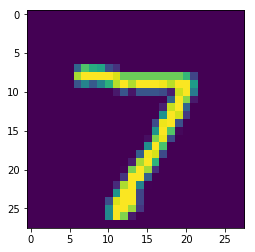

In [13]:
print('image label:', mnist_test_y[0])
plt.imshow(single_mnist_test)
plt.show()
plt.close()

In [14]:
result_in = aux_model.predict(np.reshape(single_mnist_test, (1,single_mnist_test.ravel().shape[0])))

In [15]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

max_index = [i[0] for i in enumerate(softmax(result_in[0])[0] == max(softmax(result_in[0])[0])) if i[1]]

print('The succ/failure classification:', max_index)
print('Softmax probability of in distribution:', format(result_in[1][0][0], '.2f'))

The succ/failure classification: [7]
Softmax probability of in distribution: 1.00


위 'succ/failure classification'의 출력 결과물은 model이 input 이미지를 예측한 결과물을 나타내며, softmax probability는 input 이미지가 in-distribution일 확률을 출력해줍니다.

##### 4.2. Out Distribution Case

test를 위한 out-distribution image를 만들기 위해서, 함수를 하나 가져옵니다.

In [16]:
from skimage.filters import gaussian

def add_distortion_softblur(img):
    image = img.reshape((-1, 28, 28))
    return gaussian(image, sigma=5*distortion).reshape((-1, 28*28))


noise 함수의 parameter 값들을 변경해보면서 결과물을 한번 확인해봅니다. 

image label: 7


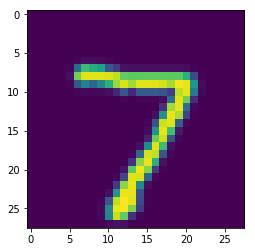

[array([[7.1756247e-11, 1.4834814e-08, 4.5618660e-09, 1.0669144e-09,
        4.6814184e-09, 6.7309863e-10, 7.5312212e-13, 9.9999988e-01,
        1.5604585e-09, 1.4507117e-07]], dtype=float32), array([[1.]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 1.00
image label: 7


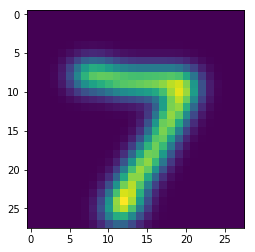

[array([[2.5450345e-06, 6.8232213e-05, 3.2428215e-05, 3.0083609e-05,
        2.5119332e-05, 2.3986368e-05, 3.0504131e-07, 9.9963331e-01,
        3.5648933e-05, 1.4833226e-04]], dtype=float32), array([[0.99999917]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 1.00
image label: 7


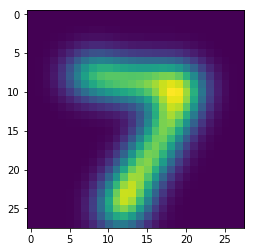

[array([[0.00357494, 0.01640276, 0.0163307 , 0.03847048, 0.01001264,
        0.02169904, 0.00179676, 0.8253786 , 0.0450325 , 0.02130158]],
      dtype=float32), array([[0.715932]], dtype=float32)]
The succ/failure classification: [7]
Softmax probability of in/out distribution: 0.72
image label: 7


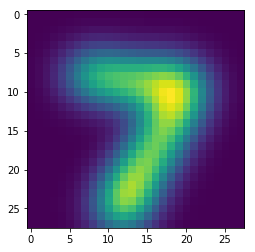

[array([[0.03632626, 0.03355033, 0.05786365, 0.1643787 , 0.03412783,
        0.10421374, 0.02817638, 0.08104628, 0.39407077, 0.06624608]],
      dtype=float32), array([[8.914607e-06]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


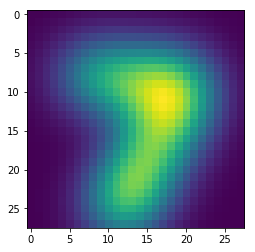

[array([[0.04894906, 0.03456604, 0.05176386, 0.09218466, 0.04079981,
        0.07285247, 0.03732511, 0.03572984, 0.5185759 , 0.06725322]],
      dtype=float32), array([[1.6759535e-06]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


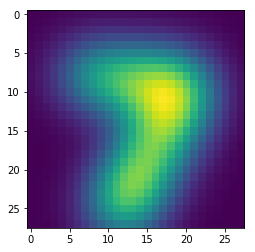

[array([[0.05157811, 0.03450062, 0.05243128, 0.09518801, 0.04058101,
        0.07631046, 0.03815284, 0.03632993, 0.5067726 , 0.06815518]],
      dtype=float32), array([[1.6856915e-06]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


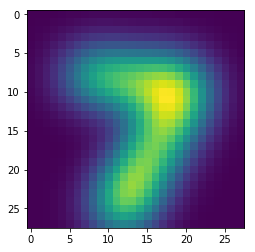

[array([[0.05633797, 0.03370544, 0.0564675 , 0.11141982, 0.03811922,
        0.08756658, 0.03834371, 0.04263442, 0.46345183, 0.07195348]],
      dtype=float32), array([[1.7943096e-06]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


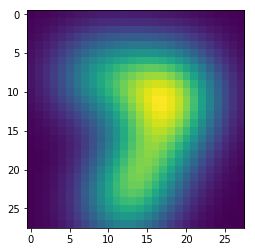

[array([[0.04352707, 0.03431216, 0.05132934, 0.08301035, 0.04155555,
        0.06630649, 0.03594276, 0.03542551, 0.54320234, 0.0653884 ]],
      dtype=float32), array([[1.6515887e-06]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


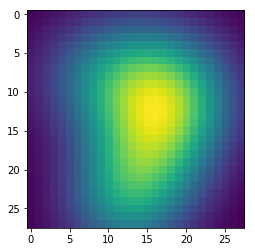

[array([[0.03304241, 0.03403548, 0.05041625, 0.06856699, 0.04166871,
        0.05381642, 0.03257558, 0.03225151, 0.59358877, 0.06003789]],
      dtype=float32), array([[8.454318e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00
image label: 7


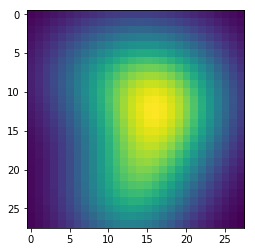

[array([[0.03312492, 0.03396811, 0.04999743, 0.06886479, 0.04154062,
        0.05405697, 0.0325096 , 0.03220134, 0.59367055, 0.06006568]],
      dtype=float32), array([[8.784747e-07]], dtype=float32)]
The succ/failure classification: [8]
Softmax probability of in/out distribution: 0.00


In [17]:
for i in np.arange(0, 2, 0.2):

    distortion = np.random.uniform(low=0.4, high= i)

    single_mnist_out_test = np.reshape(add_distortion_softblur(mnist_test_x[0]), (28, 28))

    ##### printing original image
    
    print('image label:', mnist_test_y[0])
    plt.imshow(single_mnist_out_test)
    plt.show()
    plt.close()

    result_out = aux_model.predict(np.reshape(single_mnist_out_test, (1,single_mnist_out_test.ravel().shape[0])))
    print(result_out)

    max_index = [i[0] for i in enumerate(softmax(result_out[0])[0] == max(softmax(result_out[0])[0])) if i[1]]

    ##### printing succ/fail classification and in/out classification probability result
    print('The succ/failure classification:', max_index)
    print('Softmax probability of in/out distribution:', format(result_out[1][0][0], '.2f'))

어느 정도 작동은 잘 하지만, 결과가 굉장히 민감한 걸 알 수 있습니다 (0에 가깝거나 1에 가깝거나 한 결과들이 많죠). 추측컨데, 이는 논문에서도 언급되었던 것처럼 제가 마지막에 probability를 도출하기 위해 사용한 softmax 함수 때문이 아닐까 하는 생각이 듭니다.